# Breast Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import scipy
from scipy import stats
import statsmodels.stats.multitest as ssm

In [2]:
# settings for editable pdfs
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [3]:
# # set size of tick labels
# plt.rc('xtick', labelsize=15)
# plt.rc('ytick', labelsize=15)

## Load data, preprocessing

### Load MAF data

In [4]:
# load genie version 8.1
master_mut = pd.read_csv("R_script/cleaned_data/GENIE8.1_master_list_clinical_gen.tsv", sep='\t')

/Users/jamie/opt/anaconda3/envs/singlecell/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (35,36,53) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Load panels

In [5]:
DFCI_1 = pd.read_csv('R_script/Panels/DFCI_1.txt', sep='\t')
DFCI_2 = pd.read_csv('R_script/Panels/DFCI_2.txt', sep='\t')
DFCI_3 = pd.read_csv('R_script/Panels/DFCI_3.txt', sep='\t')
DFCI_3_1 = DFCI_3.copy()

In [6]:
DFCI_1['SEQ_ASSAY_ID'] = 'DFCI-ONCOPANEL-1'
DFCI_2['SEQ_ASSAY_ID'] = 'DFCI-ONCOPANEL-2'
DFCI_3['SEQ_ASSAY_ID'] = 'DFCI-ONCOPANEL-3'
DFCI_3_1['SEQ_ASSAY_ID'] = 'DFCI-ONCOPANEL-3.1'

In [7]:
MSK_341 = pd.read_csv('R_script/Panels/IMPACT_341.txt', sep='\t')
MSK_410 = pd.read_csv('R_script/Panels/IMPACT_410.txt', sep='\t')
MSK_468 = pd.read_csv('R_script/Panels/IMPACT_468.txt', sep='\t')

In [8]:
MSK_341['SEQ_ASSAY_ID'] = 'MSK-IMPACT-341'
MSK_410['SEQ_ASSAY_ID'] = 'MSK-IMPACT-410'
MSK_468['SEQ_ASSAY_ID'] = 'MSK-IMPACT-468'

In [9]:
combined_panels = pd.concat([DFCI_1, DFCI_2, DFCI_3, DFCI_3_1, MSK_341, MSK_410, MSK_468]).groupby(
    'Hugo_Symbol')['SEQ_ASSAY_ID'].apply(list).to_frame()

### Define Variables of interest

In [10]:
cancers = ['BRCA', 'IDC', 'ILC']

centers = ['MSK', 'DFCI']

panels = ['DFCI-ONCOPANEL-1', 'DFCI-ONCOPANEL-2', 'DFCI-ONCOPANEL-3', 'DFCI-ONCOPANEL-3.1', 
                        'MSK-IMPACT-341', 'MSK-IMPACT-410', 'MSK-IMPACT-468']

races = ['Asian', 'Black', 'White']

sample_types = ['Primary', 'Metastasis']

variants = ['Missense_Mutation', 'Splice_Site', 'Nonsense_Mutation', 'Frame_Shift_Del', 
                         'Frame_Shift_Ins', 'Nonstop_Mutation', 'In_Frame_Del']

### Filter MAF data by variables of interest

In [11]:
master_mut['SEQ_ASSAY_ID'] = master_mut['SEQ_ASSAY_ID'].replace({'MSK-IMPACT341':'MSK-IMPACT-341', 
                                                                 'MSK-IMPACT410':'MSK-IMPACT-410', 
                                                                 'MSK-IMPACT468':'MSK-IMPACT-468'})

In [12]:
# (NOTE From Scanner's code: do not subset by Variant_Classification yet as that will skew our denominator and demographic numbers)

filt_mut = master_mut[(master_mut['ONCOTREE_CODE'].isin(cancers)) & (master_mut['SEQ_ASSAY_ID'].isin(panels)) & (
    master_mut['PRIMARY_RACE'].isin(races) & master_mut['SAMPLE_TYPE'].isin(sample_types))]

## Create dictionaries separated by primary/metstasis

### Non-filtered by variants

In [13]:
mut_dict = {}

In [14]:
mut_dict['prim'] = filt_mut[filt_mut['SAMPLE_TYPE'] == 'Primary']
mut_dict['met'] = filt_mut[filt_mut['SAMPLE_TYPE'] == 'Metastasis']

### Filter by variants of interest

In [15]:
# using this data for subsequent analysis

In [16]:
var_mut_dict = {}

In [17]:
# variants to include
variants = ['Missense_Mutation', 'Splice_Site', 'Nonsense_Mutation', 'Frame_Shift_Del', 
                         'Frame_Shift_Ins', 'Nonstop_Mutation', 'In_Frame_Del']

In [18]:
var_filt_mut = filt_mut[filt_mut['Variant_Classification'].isin(variants)]

In [19]:
var_mut_dict['prim'] =  var_filt_mut[var_filt_mut['SAMPLE_TYPE'] == 'Primary']
var_mut_dict['met'] = var_filt_mut[var_filt_mut['SAMPLE_TYPE'] == 'Metastasis']

## Demographic Information

In [20]:
# looking at non-filtered by variant data

In [21]:
race_demo_dict = {}
panel_demo_dict = {}

### Overall (Primary + Metastasis)

In [22]:
# total number of unique patients
len(filt_mut.groupby('PATIENT_ID').nunique())

5008

In [23]:
race_demo_dict['overall'] = filt_mut.groupby('PRIMARY_RACE')['PATIENT_ID'].nunique()
panel_demo_dict['overall'] = filt_mut.groupby('SEQ_ASSAY_ID')['PATIENT_ID'].nunique()

In [24]:
# by race
race_demo_dict['overall']

PRIMARY_RACE
Asian     324
Black     454
White    4230
Name: PATIENT_ID, dtype: int64

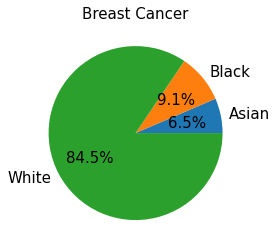

In [25]:
plt.title('Breast Cancer', size=15)
plt.pie(race_demo_dict['overall'], 
        labels=['Asian', 'Black', 'White'],
       autopct='%1.1f%%',
       textprops = dict(rotation_mode = 'anchor', 
#                         va='center', 
#                         ha='center', 
                        size=15));

In [26]:
# by panels
panel_demo_dict['overall']

SEQ_ASSAY_ID
DFCI-ONCOPANEL-1       171
DFCI-ONCOPANEL-2       707
DFCI-ONCOPANEL-3       449
DFCI-ONCOPANEL-3.1     159
MSK-IMPACT-341         329
MSK-IMPACT-410         820
MSK-IMPACT-468        2511
Name: PATIENT_ID, dtype: int64

### Primary

In [27]:
# total primary
len(mut_dict['prim'].groupby('PATIENT_ID').nunique())

2923

In [28]:
race_demo_dict['prim'] = mut_dict['prim'].groupby('PRIMARY_RACE')['PATIENT_ID'].nunique()
panel_demo_dict['prim'] = mut_dict['prim'].groupby('SEQ_ASSAY_ID')['PATIENT_ID'].nunique()

In [29]:
# by race
race_demo_dict['prim']

PRIMARY_RACE
Asian     200
Black     270
White    2453
Name: PATIENT_ID, dtype: int64

In [30]:
# by panel
panel_demo_dict['prim']

SEQ_ASSAY_ID
DFCI-ONCOPANEL-1       108
DFCI-ONCOPANEL-2       453
DFCI-ONCOPANEL-3       268
DFCI-ONCOPANEL-3.1      42
MSK-IMPACT-341         135
MSK-IMPACT-410         340
MSK-IMPACT-468        1597
Name: PATIENT_ID, dtype: int64

### Metastasis

In [31]:
# total metastasis
len(mut_dict['met'].groupby('PATIENT_ID').nunique())

2228

In [32]:
race_demo_dict['met'] = mut_dict['met'].groupby('PRIMARY_RACE')['PATIENT_ID'].nunique()
panel_demo_dict['met'] = mut_dict['met'].groupby('SEQ_ASSAY_ID')['PATIENT_ID'].nunique()

In [33]:
# by race
race_demo_dict['met']

PRIMARY_RACE
Asian     132
Black     193
White    1903
Name: PATIENT_ID, dtype: int64

In [34]:
# by panel
panel_demo_dict['met']

SEQ_ASSAY_ID
DFCI-ONCOPANEL-1       63
DFCI-ONCOPANEL-2      254
DFCI-ONCOPANEL-3      181
DFCI-ONCOPANEL-3.1    117
MSK-IMPACT-341        199
MSK-IMPACT-410        491
MSK-IMPACT-468        999
Name: PATIENT_ID, dtype: int64

## Calculate mutation frequency (for all genes)

In [35]:
# remove patients with duplicate tumors sequenced by multiple panels
# choose sample sequenced by larger panel

# mut_tbl: mutation table in MAF format
def remove_duplicates(mut_tbl):
    # group by patient and panel to find the unique sample IDs
    df = mut_tbl.groupby(['PATIENT_ID', 'SEQ_ASSAY_ID'])['SAMPLE_ID'].unique().to_frame()
    # choose the last panel for each patient
    samples = np.concatenate(df.groupby('PATIENT_ID').tail(1)['SAMPLE_ID'])
    # filter out the duplicates
    cleaned_mut = mut_tbl[mut_tbl['SAMPLE_ID'].isin(samples)]
    
    return cleaned_mut

In [36]:
# count patients sequenced by each panel by race

# mut_tbl: mutation table in MAF format
# combined_panels: table with genes as rows, lists of panels that sequenced that gene as column
# race_category: name of race column
def calc_seq_counts(mut_tbl, combined_panels, race_category):
    # first remove duplicates to get accurate sequenced count
    mut_tbl = remove_duplicates(mut_tbl)
    
    # count number of patients for each panel
    panel_race_counts = mut_tbl.groupby(['SEQ_ASSAY_ID', race_category])[
        'PATIENT_ID'].nunique().reset_index().pivot_table(index='SEQ_ASSAY_ID', columns=race_category, 
                                                          values='PATIENT_ID', fill_value=0)
    # count number of patients by race sequenced for one gene
    def sum_gene_counts(row):
        count = np.sum(panel_race_counts[panel_race_counts.index.isin(row)], axis=0)
        return count
    
    # apply function to all genes
    seq_cnt = combined_panels['SEQ_ASSAY_ID'].apply(sum_gene_counts)
    
    return seq_cnt
#     return panel_race_counts

In [37]:
# calculate mutation frequency

# mut_tbl: MAF mutation table
# var_mut_tbl: mut_tbl filtered by variants we excluded
# combined_panels: table with genes as rows, lists of panels that sequenced that gene as column
# race_category: name of race column
def calc_mut_freq(mut_tbl, var_mut_tbl, combined_panels, race_category):
    
    # calculate number of patients sequenced in each race category for all genes in panels
    seq_cnt = calc_seq_counts(mut_tbl, combined_panels, race_category)
    
    # remove duplicates before counting mutations
    var_mut_tbl = remove_duplicates(var_mut_tbl)
    
    # calculate number of patients w/ mutation in each race category for each gene in MAF table
    mut_cnt = var_mut_tbl.groupby(['Hugo_Symbol', race_category])['PATIENT_ID'].nunique().reset_index().pivot_table(
        index='Hugo_Symbol', columns=race_category, values='PATIENT_ID', fill_value=0)
    
    mut_seq = mut_cnt.join(seq_cnt, how='outer', lsuffix='_mut', rsuffix='_seq')
    
    # find any missing genes that weren't included in panel but still had mutations
    # don't know why these are included in the panel in GENIE but not elsewhere
    # total for DFCI is especially wrong (looking directly at the genomic_information.txt file)
    missing = mut_seq[mut_seq['Asian_seq'].isna()]
    
    # remove missing genes
    mut_seq = mut_seq[~mut_seq.index.isin(missing.index)]
    
#     # fill NaN mutation values with zero
#     mut_seq = mut_seq.fillna(0)

    # remove NaN mutation values (genes that were sequenced but have no mutation counts)
    mut_seq = mut_seq.dropna()
    
    # compute mutation frequency
    mut_columns = mut_seq.columns[mut_seq.columns.str.contains('_mut')]
    seq_columns = mut_seq.columns[mut_seq.columns.str.contains('_seq')]
    
    mut_freq = mut_seq[mut_columns] / mut_seq[seq_columns].values * 100
    mut_freq.columns = mut_freq.columns.str.replace('_mut', '')
    
    return mut_seq, mut_freq
    

In [38]:
mut_freq_dict = {}
mut_seq_dict = {}

In [39]:
for (k1, v1), (k2, v2) in zip(mut_dict.items(), var_mut_dict.items()):
    mut_seq_dict[k1], mut_freq_dict[k1] = calc_mut_freq(v1, v2, combined_panels, 'PRIMARY_RACE')

## Significance testing functions

### Fisher's Test and FDR

In [40]:
# performs Fisher's exact test for one gene between two races and calculates 95% confidence interval

# row: gene row
# group1: name of first race
# group2: name of second race
def fisher_one_gene(row, group1, group2):
    seq_group1 = row[group1 + '_seq']
    seq_group2 = row[group2 + '_seq']
    
    mut_group1 = row[group1 + '_mut']
    mut_group2 = row[group2 + '_mut']
    
    a = mut_group1
    b = mut_group2
    c = seq_group1 - a
    d = seq_group2 - b
    
    cont_tbl = pd.DataFrame(np.array([[a, c],
                                     [b, d]]), index=[group1, group2], columns=['Mutation', 'No Mutation'])
    
    odds_ratio, p_val = scipy.stats.fisher_exact(cont_tbl)
    
    # calculate 95% confidence interval    
    SE = np.sqrt(1/a + 1/c + 1/b + 1/d) 
    
    c1 = round(odds_ratio * np.exp(-1.96 * SE), 3)
    c2 = round(odds_ratio * np.exp(1.96 * SE), 3)
    
    CI = (c1, c2)
    
    return cont_tbl, odds_ratio, p_val, CI

In [41]:
# performs Fisher's exact test for all genes between two races and computes FDR

# mut_tbl: table with genes as rows and *_mut/*_seq counts as columns (* is name of race group)
# group1: name of first race
# group2: name of second race

def fisher_all_genes(mut_tbl, group1, group2):
    fisher = mut_tbl.apply(lambda x: fisher_one_gene(x, group1, group2), axis=1)
    
    fisher_tbl = pd.DataFrame(fisher.to_list(), index=fisher.index).iloc[:,1:].rename(
        columns={1:group1 + '_' + group2 + '_odds_ratio', 
                 2:group1 + '_' + group2 + '_pval', 
                 3:group1 + '_' + group2 + '_CI'})
    fdr = ssm.multipletests(fisher_tbl[group1 + '_' + group2 + '_pval'], method='fdr_bh')[1]
    fisher_tbl.insert(2, group1 + '_' + group2 + '_fdr', fdr)
    
    return fisher_tbl

In [42]:
# performs Fisher's exact test for all race comparisons, and computes FDR

# mut_tbl: table with genes as rows and *_mut/*_seq counts as columns (* is name of race group)
# groups: list of tuples with race comparisons
def fisher_fdr_all_groups(mut_tbl, groups):
    fisher_tbl = pd.DataFrame()
    for group in groups:
        fisher_tbl = pd.concat([fisher_tbl, fisher_all_genes(mut_tbl, group[0], group[1])], axis=1)

    return fisher_tbl

In [43]:
# change if doing different comparisons
groups = [('Black', 'White'), 
          ('Black', 'Asian'), 
          ('Asian', 'White')]

### Significant genes

In [44]:
# finds significant genes based on FDR cutoff specified

# pvals: table of p-values, genes as rows, race comparisons as columns
# mut_freq: table of mutation frequencies, genes as rows, races as columns
# fdr_cutoff: float
def find_sig_genes(pvals, mut_freq, fdr_cutoff):
    cols = pvals.columns[pvals.columns.str.contains('fdr')]
    pval_cols = pvals[cols]    
    
    sig_pval = pval_cols[(pval_cols <= fdr_cutoff).any(1)]
    sig_genes = sig_pval.index
    sig_pval = pvals.loc[sig_genes]
    
    sig_pct = mut_freq.loc[sig_genes]
    
    return sig_genes.to_list(), sig_pval, sig_pct

In [45]:
# finds significant genes for all groups

# race_pairs: list of tuples with race comparisons
# pvals: table of p-values, genes as rows, race comparisons as columns
# mut_freq: table of mutation frequencies, genes as rows, races as columns
# fdr_cutoff: float
def find_sig_genes_groups(race_pairs, pvals, mut_freq, fdr_cutoff):
    sig_pval_dict = {}
    sig_freq_dict = {}
    sig_gene_list = []
    for pair in race_pairs:
        pair_cols = ['_'.join(pair) + '_pval', '_'.join(pair) + '_fdr', 
                     '_'.join(pair) + '_odds_ratio', '_'.join(pair) + '_CI']
        pair_pval = pvals[pair_cols]
        pair_mut_freq = mut_freq[[pair[0], pair[1]]]
        sig_genes, sig_pval_dict[pair], sig_freq_dict[pair] = find_sig_genes(pair_pval, pair_mut_freq, fdr_cutoff)
        sig_gene_list = sig_gene_list + sig_genes
    
    # remove duplicates
    sig_gene_list = set(sig_gene_list)
    
    return sig_gene_list, sig_pval_dict, sig_freq_dict

## Composition plot functions

### Variant Composition Plots

In [46]:
# calculate variant composition for genes of interest

# mut_tbl: MAF table
# genes: list of genes of interest
def variant_comp(mut_tbl, genes):
    # filter mut_tbl by genes of interest
    filt_mut = mut_tbl[mut_tbl['Hugo_Symbol'].isin(genes)]
    comp_mut = filt_mut.groupby(['Hugo_Symbol', 'Variant_Classification'])['PATIENT_ID'].nunique().reset_index().pivot_table(
        index='Hugo_Symbol', columns='Variant_Classification', values='PATIENT_ID', fill_value=0)
    pct_mut = comp_mut.div(comp_mut.sum(axis=1), axis=0) * 100
    
    return comp_mut, pct_mut

### Panel Composition Plots

In [47]:
# calculate panel composition for genes of interest

# mut_tbl: MAF table
# genes: list of genes of interest
def panel_comp(mut_tbl, genes):
    # filter mut_tbl by genes of interest
    filt_mut = mut_tbl[mut_tbl['Hugo_Symbol'].isin(genes)]
    comp_mut = filt_mut.groupby(['Hugo_Symbol', 'SEQ_ASSAY_ID'])['PATIENT_ID'].nunique().reset_index().pivot_table(
        index='Hugo_Symbol', columns='SEQ_ASSAY_ID', values='PATIENT_ID', fill_value=0)
    pct_mut = comp_mut.div(comp_mut.sum(axis=1), axis=0) * 100
    
    return comp_mut, pct_mut

## Top Mutations

### Find genes most frequently altered overall and by race

In [48]:
# calculate mutations most common in all patients, count number of patients with that mutation

# mut_tbl: MAF table
def common_mut_overall(mut_tbl):
    common_mut = mut_tbl.groupby('Hugo_Symbol')['PATIENT_ID'].nunique().sort_values(ascending=False)
    
    return common_mut

In [49]:
# most common mutations for each race

# mut_tbl: MAF table
# race_category: race column name
# races: list of races of interest
def common_mut_race(mut_tbl, race_category, races):    
    common_dict = {}
    
    for race in races:
        race_tbl = mut_tbl[mut_tbl[race_category] == race]
        common_tbl = common_mut_overall(race_tbl)
        common_dict[race] = common_tbl
        
    return common_dict

In [50]:
common_mut_dict = {}

In [51]:
for key, value in var_mut_dict.items():
    common_mut_dict[key] = common_mut_overall(value)

In [52]:
common_mut_race_dict = {}

In [53]:
for key, value in var_mut_dict.items():
    common_mut_race_dict[key] = common_mut_race(value, 'PRIMARY_RACE', ['Asian', 'Black', 'White'])   

### Top 20 mutations overall

In [54]:
# top 20 primary
common_mut_dict['prim'].head(20)

Hugo_Symbol
TP53      1195
PIK3CA    1088
GATA3      413
CDH1       380
MAP3K1     225
PTEN       211
ARID1A     157
KMT2C      154
AKT1       132
CBFB       131
KMT2D      124
TBX3       117
BRCA2      112
NF1        108
MAP2K4     107
RUNX1      104
RB1         88
NOTCH1      87
FOXA1       84
KMT2A       81
Name: PATIENT_ID, dtype: int64

In [55]:
# top 20 metastatic
common_mut_dict['met'].head(20)

Hugo_Symbol
TP53      966
PIK3CA    799
CDH1      353
GATA3     313
ESR1      308
MAP3K1    185
ARID1A    168
KMT2C     155
PTEN      154
NF1       142
KMT2D     138
AKT1      125
BRCA2     110
FAT1      103
TBX3      103
FOXA1     101
ATM        98
ERBB2      96
MAP2K4     92
RB1        89
Name: PATIENT_ID, dtype: int64

In [56]:
top_mut_seq_dict = {}
top_mut_freq_dict = {}

In [57]:
for key, value in common_mut_dict.items():
    top_20 = value.head(20).index
    top_mut_seq_dict[key] = mut_seq_dict[key].loc[top_20]
    top_mut_freq_dict[key] = mut_freq_dict[key].loc[top_20]

## TumorPortal genes

### Subset mutation data by tumor portal genes

In [58]:
# load tumor portal genes
genes = pd.read_csv('R_script/cleaned_data/sig_mut_genes_breast.txt', sep='\t')

In [59]:
# remove TumorPortal genes that are not in data
prim_genes = genes[genes['Hugo_Symbol'].isin(mut_seq_dict['prim'].index)]  
met_genes = genes[genes['Hugo_Symbol'].isin(mut_seq_dict['met'].index)]

In [60]:
# check genes are same among prim and met data
# if numbers are different, need to change downstream analysis
print(len(genes), len(prim_genes), len(met_genes))

32 26 26


In [61]:
prim_genes == met_genes

,Hugo_Symbol
0,True
1,True
2,True
3,True
5,True
6,True
7,True
8,True
9,True
10,True


In [62]:
# from here assuming that Tumor Portal genes are the same in prim and met datasets
# both prim and met have the same tumor portal genes of interest
# if not all True in printouts above, need to modify code

In [63]:
tp_mut_seq_dict = {}
tp_mut_freq_dict = {}

In [64]:
for (k1, v1), (k2, v2) in zip(mut_seq_dict.items(), mut_freq_dict.items()):
    tp_mut_seq_dict[k1] = v1.loc[prim_genes.iloc[:,0]]
    tp_mut_freq_dict[k1] = v2.loc[prim_genes.iloc[:,0]]

## Top 20 + Tumor Portal Combined

### Combine Top 20 + TP data together

In [65]:
# use these for prevalence bar charts
comb_mut_seq_dict = {}
comb_mut_freq_dict = {}

In [66]:
for (k1, v1), (k2, v2) in zip(top_mut_seq_dict.items(), tp_mut_seq_dict.items()):
    comb_mut_seq_dict[k1] = pd.concat([v1, v2]).drop_duplicates()

In [67]:
for (k1, v1), (k2, v2) in zip(top_mut_freq_dict.items(), tp_mut_freq_dict.items()):
    comb_mut_freq_dict[k1] = pd.concat([v1, v2]).drop_duplicates()

### Fisher's Test and FDR

In [68]:
# outer join Top 20 primary and metastatic genes together for FDR calculation
# so we can compare genes from both in FDR scatter plots

In [69]:
# for visualization, these are the genes from Top 20 primary not in Top 20 metastasis
comb_mut_seq_dict['prim'][~comb_mut_seq_dict['prim'].index.isin(comb_mut_seq_dict['met'].index)].index

Index(['NOTCH1', 'KMT2A'], dtype='object', name='Hugo_Symbol')

In [70]:
comb_mut_seq_dict['met'][~comb_mut_seq_dict['met'].index.isin(comb_mut_seq_dict['prim'].index)].index

Index(['ESR1', 'FAT1', 'ATM'], dtype='object', name='Hugo_Symbol')

In [71]:
comb_genes = comb_mut_seq_dict['prim'].index | comb_mut_seq_dict['met'].index

In [72]:
comb_pm_mut_seq_dict = {}
comb_pm_mut_freq_dict = {}

In [73]:
for (k1, v1), (k2, v2) in zip(mut_seq_dict.items(), mut_freq_dict.items()):
    comb_pm_mut_seq_dict[k1] = v1.loc[comb_genes]
    comb_pm_mut_freq_dict[k1] = v2.loc[comb_genes]

In [74]:
comb_pval_dict = {}

In [75]:
for key, value in comb_pm_mut_seq_dict.items():
    comb_pval_dict[key] = fisher_fdr_all_groups(value, groups)

<ipython-input-40-ce1fee6a180c>:24: RuntimeWarning: divide by zero encountered in double_scalars
  SE = np.sqrt(1/a + 1/c + 1/b + 1/d)
<ipython-input-40-ce1fee6a180c>:27: RuntimeWarning: invalid value encountered in double_scalars
  c2 = round(odds_ratio * np.exp(1.96 * SE), 3)
<ipython-input-40-ce1fee6a180c>:26: RuntimeWarning: invalid value encountered in double_scalars
  c1 = round(odds_ratio * np.exp(-1.96 * SE), 3)


### Significant genes

In [76]:
comb_sig_pval_dict = {}
comb_sig_freq_dict = {}
comb_sig_genes_dict = {}

In [77]:
for (k1, v1), (k2, v2) in zip(comb_pval_dict.items(), comb_pm_mut_freq_dict.items()):
    comb_sig_genes_dict[k1], comb_sig_pval_dict[k1], comb_sig_freq_dict[k1] = find_sig_genes_groups(
        groups, v1, v2, 0.05)

#### Primary

In [78]:
comb_sig_pval_dict['prim']

{('Black',
  'White'):              Black_White_pval  Black_White_fdr  Black_White_odds_ratio  \
 Hugo_Symbol                                                              
 CDH1             1.785880e-03     3.125290e-02                0.488812   
 TP53             9.622215e-13     3.367775e-11                2.524973   
 
              Black_White_CI  
 Hugo_Symbol                  
 CDH1         (0.306, 0.782)  
 TP53         (1.951, 3.268)  ,
 ('Black',
  'Asian'):              Black_Asian_pval  Black_Asian_fdr  Black_Asian_odds_ratio  \
 Hugo_Symbol                                                              
 TP53                  0.00038         0.013313                1.959872   
 
             Black_Asian_CI  
 Hugo_Symbol                 
 TP53         (1.352, 2.84)  ,
 ('Asian',
  'White'): Empty DataFrame
 Columns: [Asian_White_pval, Asian_White_fdr, Asian_White_odds_ratio, Asian_White_CI]
 Index: []}

In [79]:
comb_sig_freq_dict['prim']

{('Black',
  'White'): PRIMARY_RACE      Black      White
 Hugo_Symbol                       
 CDH1           7.407407  14.064411
 TP53          61.111111  38.361190,
 ('Black',
  'Asian'): PRIMARY_RACE      Black  Asian
 Hugo_Symbol                   
 TP53          61.111111   44.5,
 ('Asian',
  'White'): Empty DataFrame
 Columns: [Asian, White]
 Index: []}

In [80]:
comb_mut_freq_dict['prim'].loc[comb_sig_genes_dict['prim']]

PRIMARY_RACE,Asian,Black,White
Hugo_Symbol,,,
TP53,44.5,61.111111,38.361190
CDH1,7.5,7.407407,14.064411


In [81]:
comb_pval_dict['prim'].loc[comb_sig_genes_dict['prim']]

,Black_White_odds_ratio,Black_White_pval,Black_White_fdr,Black_White_CI,Black_Asian_odds_ratio,Black_Asian_pval,Black_Asian_fdr,Black_Asian_CI,Asian_White_odds_ratio,Asian_White_pval,Asian_White_fdr,Asian_White_CI
Hugo_Symbol,,,,,,,,,,,,
TP53,2.524973,9.622215e-13,3.367775e-11,"(1.951, 3.268)",1.959872,0.00038,0.013313,"(1.352, 2.84)",1.288336,0.096782,0.531915,"(0.964, 1.723)"
CDH1,0.488812,1.785880e-03,3.125290e-02,"(0.306, 0.782)",0.986667,1.00000,1.000000,"(0.492, 1.979)",0.495417,0.007133,0.249644,"(0.289, 0.849)"


#### Asian vs White

In [82]:
comb_sig_pval_dict['prim'][('Asian', 'White')]

,Asian_White_pval,Asian_White_fdr,Asian_White_odds_ratio,Asian_White_CI
Hugo_Symbol,,,,


In [83]:
comb_sig_freq_dict['prim'][('Asian', 'White')]

PRIMARY_RACE,Asian,White
Hugo_Symbol,,


#### Black vs White

In [84]:
comb_sig_pval_dict['prim'][('Black', 'White')]

,Black_White_pval,Black_White_fdr,Black_White_odds_ratio,Black_White_CI
Hugo_Symbol,,,,
CDH1,1.785880e-03,3.125290e-02,0.488812,"(0.306, 0.782)"
TP53,9.622215e-13,3.367775e-11,2.524973,"(1.951, 3.268)"


In [85]:
comb_sig_freq_dict['prim'][('Black', 'White')]

PRIMARY_RACE,Black,White
Hugo_Symbol,,
CDH1,7.407407,14.064411
TP53,61.111111,38.361190


#### Black vs Asian

In [86]:
comb_sig_pval_dict['prim'][('Black', 'Asian')]

,Black_Asian_pval,Black_Asian_fdr,Black_Asian_odds_ratio,Black_Asian_CI
Hugo_Symbol,,,,
TP53,0.00038,0.013313,1.959872,"(1.352, 2.84)"


In [87]:
comb_sig_freq_dict['prim'][('Black', 'Asian')]

PRIMARY_RACE,Black,Asian
Hugo_Symbol,,
TP53,61.111111,44.5


#### Metastasis

In [88]:
comb_sig_pval_dict['met']

{('Black',
  'White'):              Black_White_pval  Black_White_fdr  Black_White_odds_ratio  \
 Hugo_Symbol                                                              
 CDH1                 0.000454         0.015698                0.410685   
 PIK3CA               0.000897         0.015698                0.568906   
 
              Black_White_CI  
 Hugo_Symbol                  
 CDH1         (0.239, 0.705)  
 PIK3CA       (0.405, 0.799)  ,
 ('Black',
  'Asian'): Empty DataFrame
 Columns: [Black_Asian_pval, Black_Asian_fdr, Black_Asian_odds_ratio, Black_Asian_CI]
 Index: [],
 ('Asian',
  'White'): Empty DataFrame
 Columns: [Asian_White_pval, Asian_White_fdr, Asian_White_odds_ratio, Asian_White_CI]
 Index: []}

In [89]:
comb_sig_freq_dict['met']

{('Black',
  'White'): PRIMARY_RACE      Black      White
 Hugo_Symbol                       
 CDH1           7.772021  17.025749
 PIK3CA        24.870466  36.784025,
 ('Black',
  'Asian'): Empty DataFrame
 Columns: [Black, Asian]
 Index: [],
 ('Asian',
  'White'): Empty DataFrame
 Columns: [Asian, White]
 Index: []}

In [90]:
comb_mut_freq_dict['met'].loc[comb_sig_genes_dict['met']]

PRIMARY_RACE,Asian,Black,White
Hugo_Symbol,,,
PIK3CA,37.878788,24.870466,36.784025
CDH1,9.848485,7.772021,17.025749


In [91]:
comb_pval_dict['met'].loc[comb_sig_genes_dict['met']]

,Black_White_odds_ratio,Black_White_pval,Black_White_fdr,Black_White_CI,Black_Asian_odds_ratio,Black_Asian_pval,Black_Asian_fdr,Black_Asian_CI,Asian_White_odds_ratio,Asian_White_pval,Asian_White_fdr,Asian_White_CI
Hugo_Symbol,,,,,,,,,,,,
PIK3CA,0.568906,0.000897,0.015698,"(0.405, 0.799)",0.542897,0.013947,0.459373,"(0.336, 0.877)",1.047909,0.852054,1.000000,"(0.728, 1.508)"
CDH1,0.410685,0.000454,0.015698,"(0.239, 0.705)",0.771392,0.549469,0.769257,"(0.354, 1.68)",0.532394,0.029460,0.515558,"(0.297, 0.956)"


#### Asian vs White

In [92]:
comb_sig_pval_dict['met'][('Asian', 'White')]

,Asian_White_pval,Asian_White_fdr,Asian_White_odds_ratio,Asian_White_CI
Hugo_Symbol,,,,


In [93]:
comb_sig_freq_dict['met'][('Asian', 'White')]

PRIMARY_RACE,Asian,White
Hugo_Symbol,,


#### Black vs White

In [94]:
comb_sig_pval_dict['met'][('Black', 'White')]

,Black_White_pval,Black_White_fdr,Black_White_odds_ratio,Black_White_CI
Hugo_Symbol,,,,
CDH1,0.000454,0.015698,0.410685,"(0.239, 0.705)"
PIK3CA,0.000897,0.015698,0.568906,"(0.405, 0.799)"


In [95]:
comb_sig_freq_dict['met'][('Black', 'White')]

PRIMARY_RACE,Black,White
Hugo_Symbol,,
CDH1,7.772021,17.025749
PIK3CA,24.870466,36.784025


#### Black vs Asian

In [96]:
comb_sig_pval_dict['met'][('Black', 'Asian')]

,Black_Asian_pval,Black_Asian_fdr,Black_Asian_odds_ratio,Black_Asian_CI
Hugo_Symbol,,,,


In [97]:
comb_sig_freq_dict['met'][('Black', 'Asian')]

PRIMARY_RACE,Black,Asian
Hugo_Symbol,,


### Mutation Prevalence Plots

#### Primary Genes

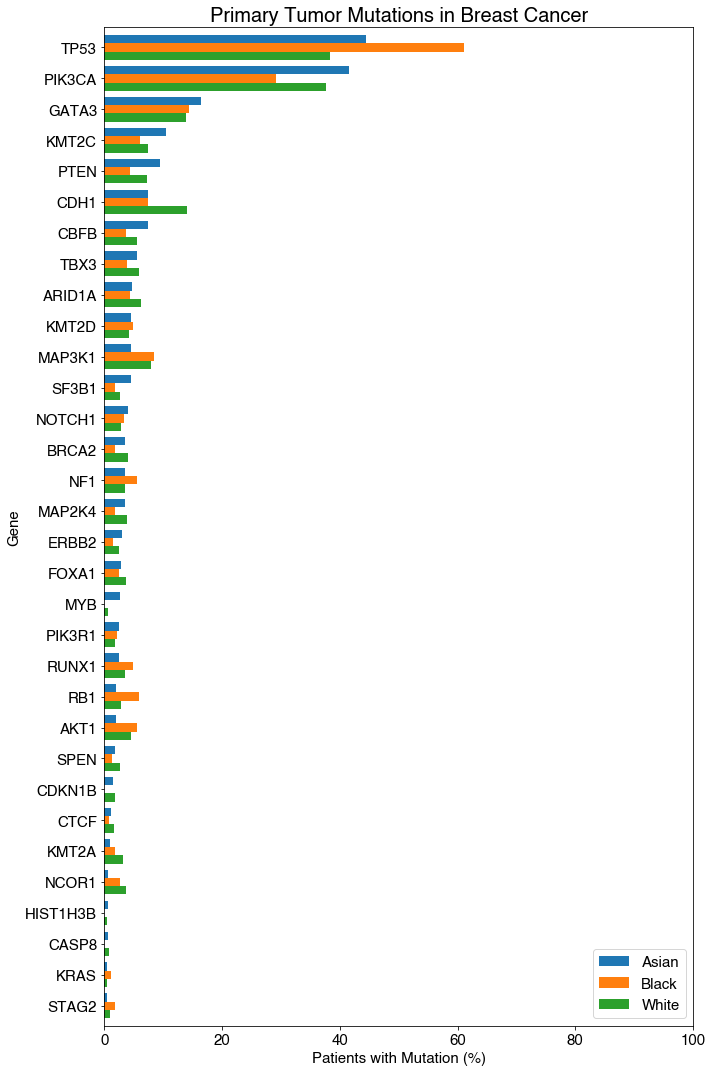

In [98]:
df = comb_mut_freq_dict['prim'].sort_values(['Asian'], ascending=False)
ax = df.plot(kind='barh', figsize=(10, 15), width=0.8)
hfont = {'fontname':'Helvetica'}
plt.title('Primary Tumor Mutations in Breast Cancer', fontsize=20, **hfont)
plt.xlabel('Patients with Mutation (%)', fontsize=15, **hfont)
plt.ylabel('Gene', fontsize=15, **hfont)
plt.xticks(size=15, **hfont)
plt.yticks(size=15, **hfont)
plt.xlim((0, 100))
ax.invert_yaxis()
plt.legend(prop={'family':'Helvetica', 'size': 15}, loc='lower right')
plt.tight_layout()
# plt.savefig('figures/breast/Top20+Tumor_Portal/breast_top20+TP_prim.pdf')

#### Metastatic Genes

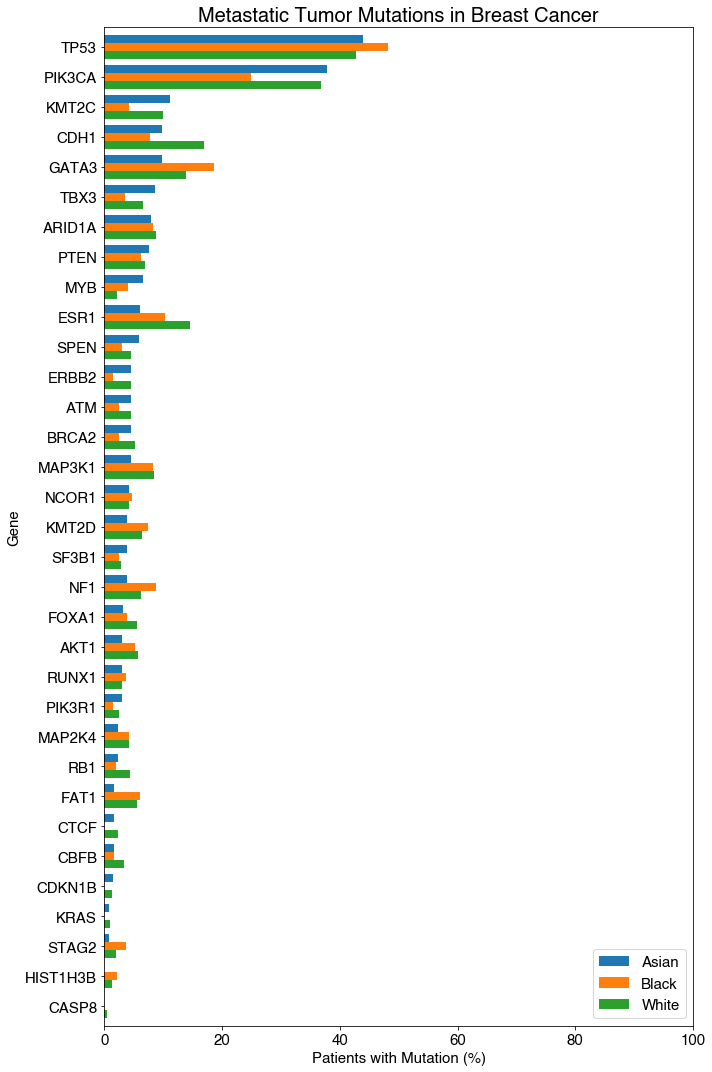

In [99]:
df = comb_mut_freq_dict['met'].sort_values(['Asian'], ascending=False)
ax = df.plot(kind='barh', figsize=(10, 15), width=0.8)
hfont = {'fontname':'Helvetica'}
plt.title('Metastatic Tumor Mutations in Breast Cancer', fontsize=20, **hfont)
plt.xlabel('Patients with Mutation (%)', fontsize=15, **hfont)
plt.ylabel('Gene', fontsize=15, **hfont)
plt.xticks(size=15, **hfont)
plt.yticks(size=15, **hfont)
plt.xlim((0, 100))
ax.invert_yaxis()
plt.legend(prop={'family':'Helvetica', 'size': 15}, loc='lower right')
plt.tight_layout()
# plt.savefig('figures/breast/Top20+Tumor_Portal/breast_top20+TP_met.pdf')

### Variant Composition Plots

In [100]:
comb_var_comp_cnt_dict = {}
comb_var_comp_pct_dict = {}

In [101]:
for (k1, v1), (k2, v2) in zip(var_mut_dict.items(), comb_mut_freq_dict.items()):
    comb_var_comp_cnt_dict[k1], comb_var_comp_pct_dict[k1] = variant_comp(v1, v2.index)

#### Primary

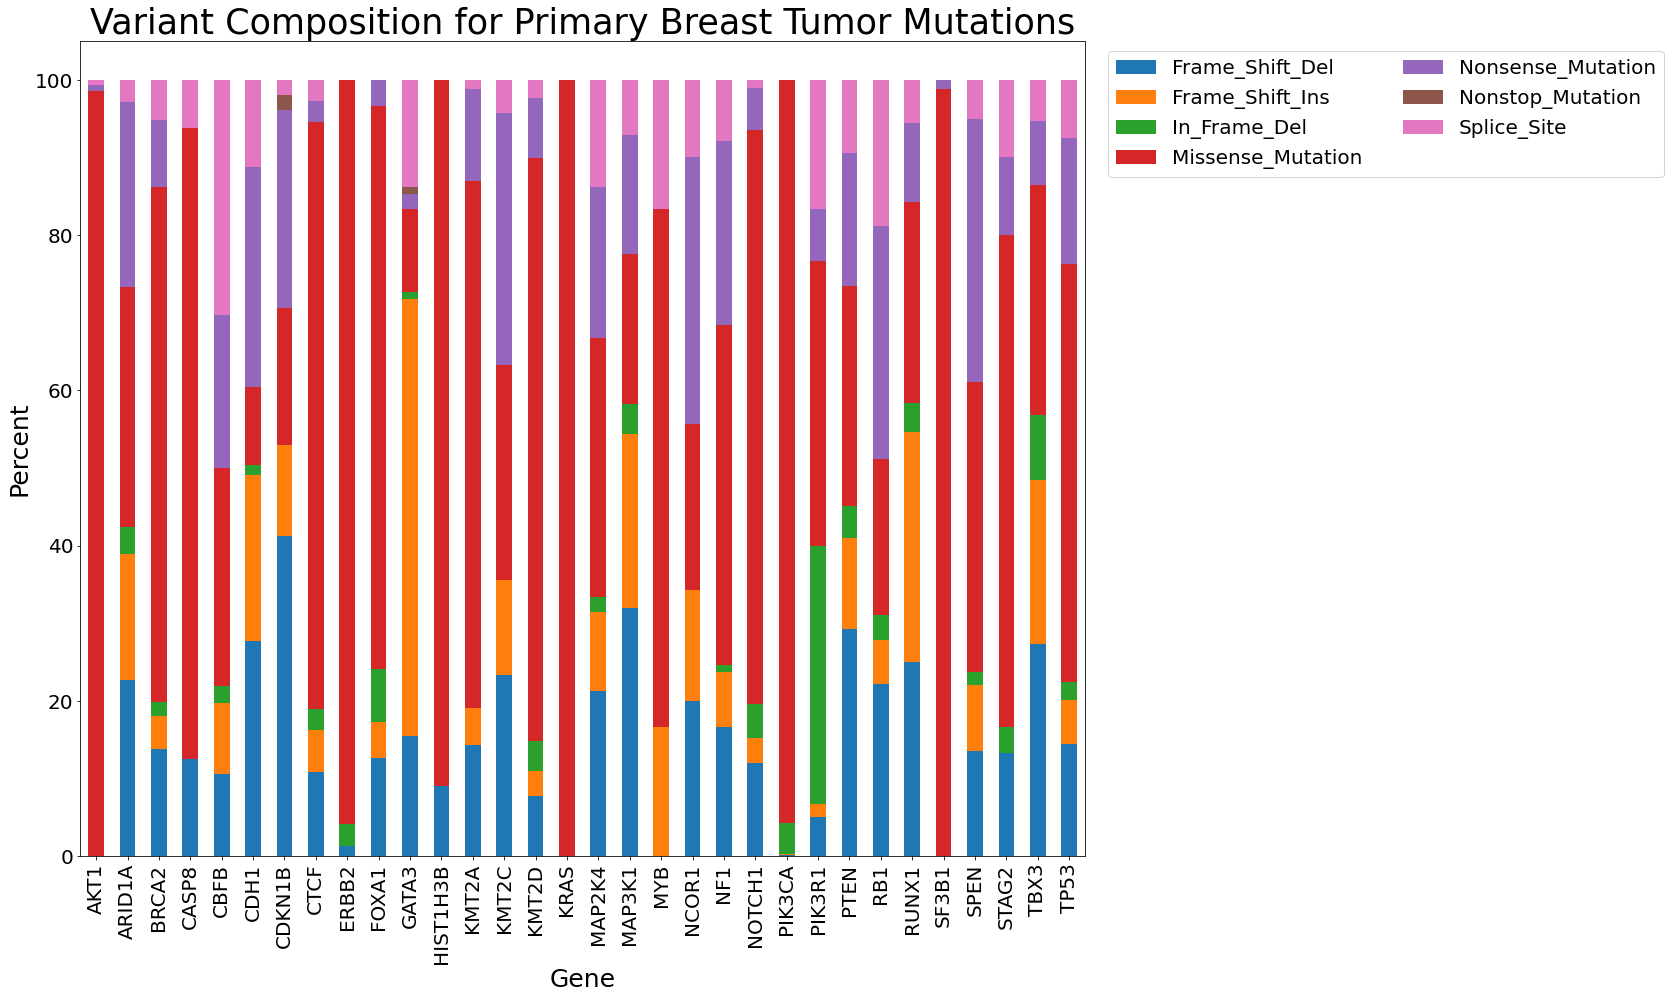

In [102]:
ax = comb_var_comp_pct_dict['prim'].plot(kind='bar', stacked=True, figsize=(30, 15))
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1), ncol=2, prop={'size':20})
plt.title("Variant Composition for Primary Breast Tumor Mutations", size=35)
plt.xlabel('Gene', size=25)
plt.ylabel('Percent', size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

#### Metastasis

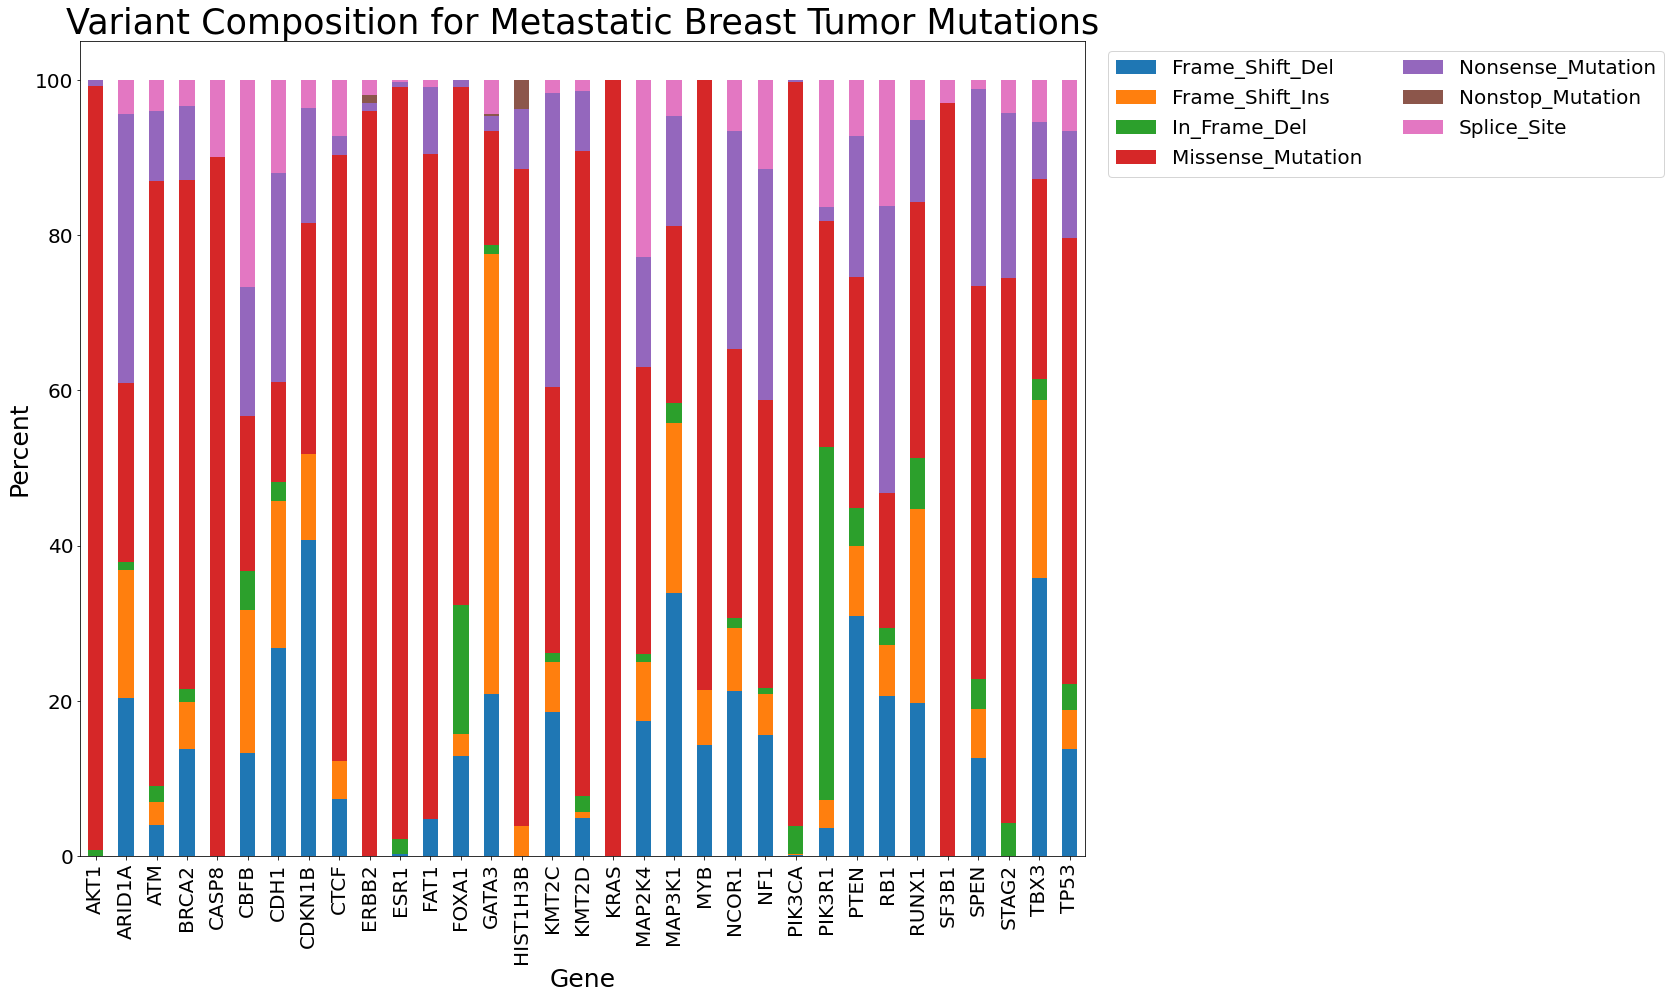

In [103]:
ax = comb_var_comp_pct_dict['met'].plot(kind='bar', stacked=True, figsize=(30, 15))
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1), ncol=2, prop={'size':20})
plt.title("Variant Composition for Metastatic Breast Tumor Mutations", size=35)
plt.xlabel('Gene', size=25)
plt.ylabel('Percent', size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

### Panel Composition Plots

In [104]:
comb_panel_comp_cnt_dict = {}
comb_panel_comp_pct_dict = {}

In [105]:
for (k1, v1), (k2, v2) in zip(var_mut_dict.items(), comb_mut_freq_dict.items()):
    comb_panel_comp_cnt_dict[k1], comb_panel_comp_pct_dict[k1] = panel_comp(v1, v2.index)

#### Primary

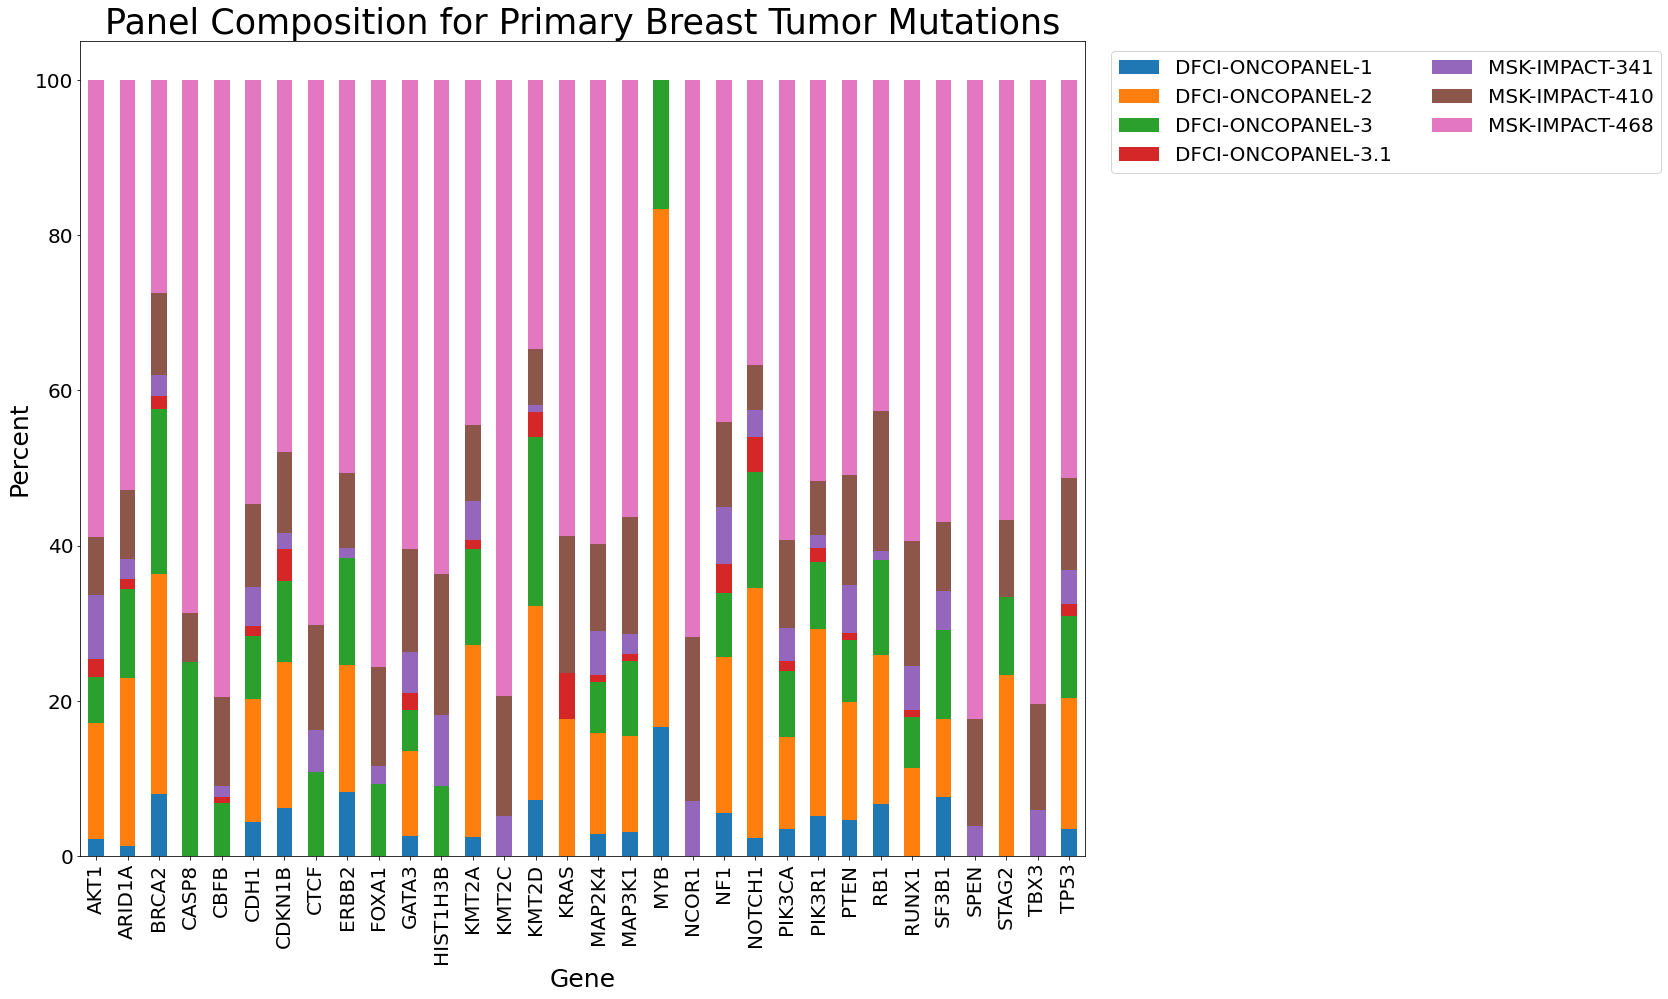

In [106]:
ax = comb_panel_comp_pct_dict['prim'].plot(kind='bar', stacked=True, figsize=(30, 15))
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1), ncol=2, prop={'size':20})
plt.title("Panel Composition for Primary Breast Tumor Mutations", size=35)
plt.xlabel('Gene', size=25)
plt.ylabel('Percent', size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

#### Metastasis

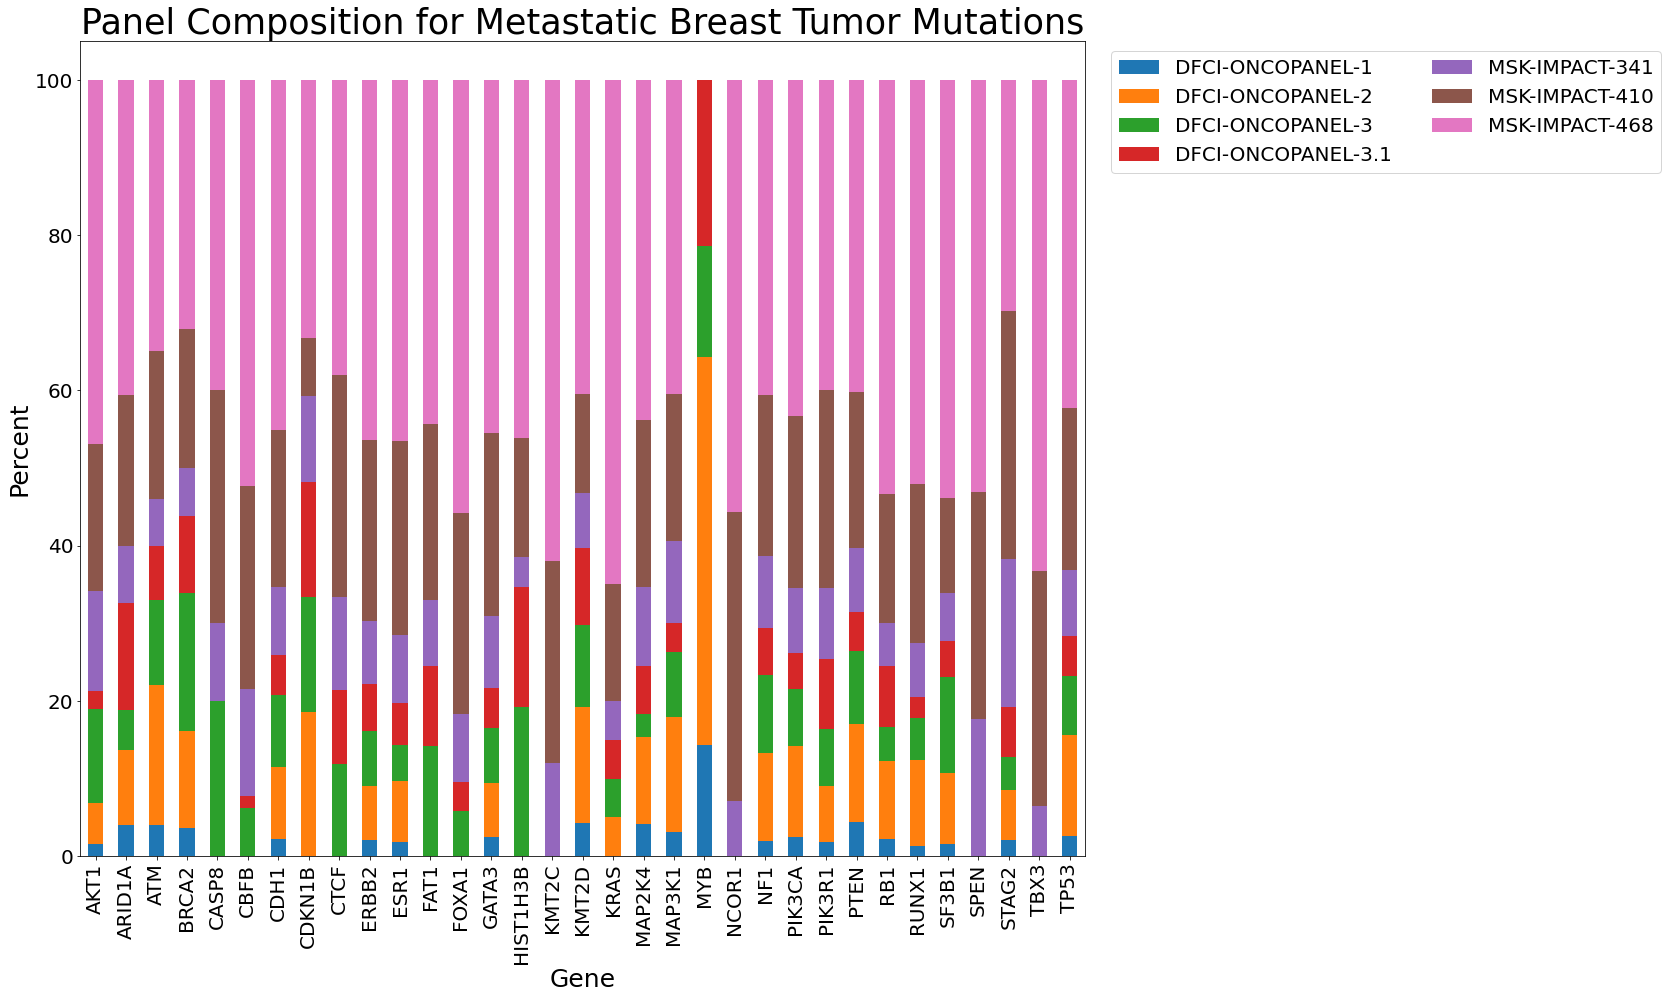

In [107]:
ax = comb_panel_comp_pct_dict['met'].plot(kind='bar', stacked=True, figsize=(30, 15))
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1), ncol=2, prop={'size':20})
plt.title("Panel Composition for Metastatic Breast Tumor Mutations", size=35)
plt.xlabel('Gene', size=25)
plt.ylabel('Percent', size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

### Main Figures

In [108]:
from adjustText import adjust_text

In [109]:
x_prim = np.log10(comb_pval_dict['prim'][['Black_White_fdr', 'Black_Asian_fdr', 'Asian_White_fdr']])
x_met = -np.log10(comb_pval_dict['met'][['Black_White_fdr', 'Black_Asian_fdr', 'Asian_White_fdr']])

In [110]:
def label_outliers(x, y, labels, x_min, y_min):
    # label points that pass thresholds
    x_pass = []
    y_pass = []
    genes_pass = []
    for a, b, c in zip(x, y, labels):
        if abs(a) >= x_min and abs(b) >= y_min:
            x_pass.append(a)
            y_pass.append(b)
            genes_pass.append(c)
            
    return list(zip(x_pass, y_pass, genes_pass))

In [111]:
split_y_prim_AW = comb_pm_mut_freq_dict['prim']['Asian'] - comb_pm_mut_freq_dict['prim']['White']
split_y_prim_BW = comb_pm_mut_freq_dict['prim']['Black'] - comb_pm_mut_freq_dict['prim']['White']
split_y_prim_BA = comb_pm_mut_freq_dict['prim']['Black'] - comb_pm_mut_freq_dict['prim']['Asian']

In [112]:
split_y_met_AW = comb_pm_mut_freq_dict['met']['Asian'] - comb_pm_mut_freq_dict['met']['White']
split_y_met_BW = comb_pm_mut_freq_dict['met']['Black'] - comb_pm_mut_freq_dict['met']['White']
split_y_met_BA = comb_pm_mut_freq_dict['met']['Black'] - comb_pm_mut_freq_dict['met']['Asian']

''

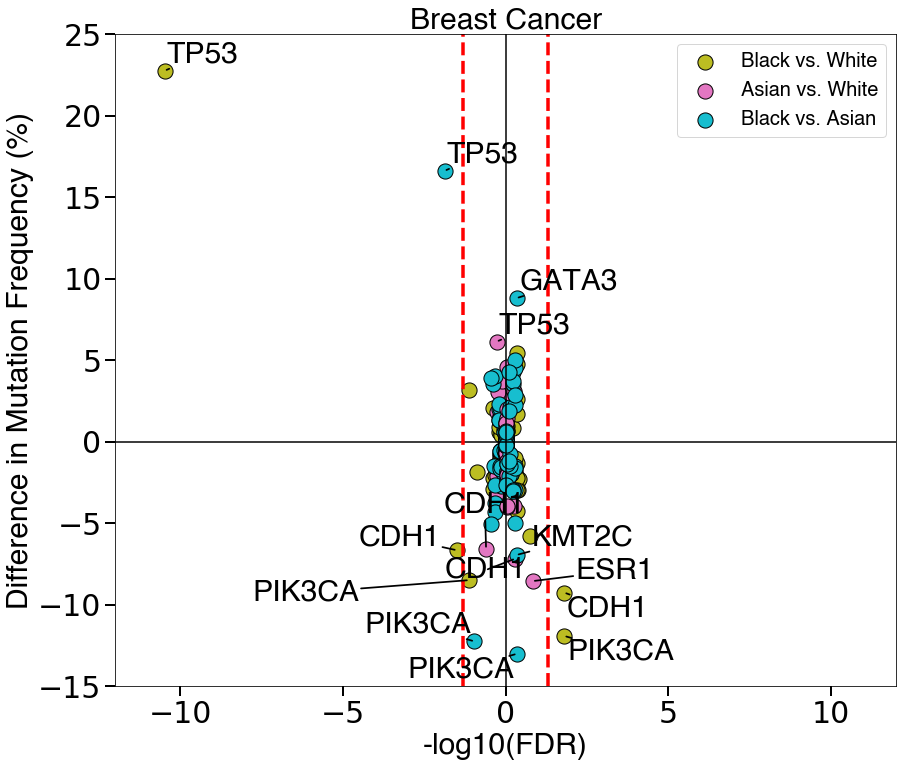

In [113]:
# Split y-axis

fig = plt.figure(figsize=(14, 12))
# fig.patch.set_facecolor('white')

plt.scatter(x_prim['Black_White_fdr'], split_y_prim_BW, label='Black vs. White', s=230, c='tab:olive', edgecolors='black')
plt.scatter(x_prim['Asian_White_fdr'], split_y_prim_AW, label='Asian vs. White', s=230, c='tab:pink', edgecolors='black')
plt.scatter(x_prim['Black_Asian_fdr'], split_y_prim_BA, label='Black vs. Asian', s=230, c='tab:cyan', edgecolors='black')

plt.scatter(x_met['Black_White_fdr'], split_y_met_BW, s=230, c='tab:olive', edgecolors='black')
plt.scatter(x_met['Asian_White_fdr'], split_y_met_AW, s=230, c='tab:pink', edgecolors='black')
plt.scatter(x_met['Black_Asian_fdr'], split_y_met_BA, s=230, c='tab:cyan', edgecolors='black')

plt.axvline(x=0, c='black')
plt.axhline(y=0, c='black')

# plot significance lines
plt.axvline(x=-np.log10(0.05), c='red', linestyle='dashed', linewidth=3.5)
plt.axvline(x=np.log10(0.05), c='red', linestyle='dashed', linewidth=3.5)

hfont = {'fontname':'Helvetica'}
plt.title('Breast Cancer', size=30, **hfont)
plt.xlabel('-log10(FDR)', size=30, **hfont)
plt.ylabel('Difference in Mutation Frequency (%)', size=30, **hfont)
plt.xlim(-12, 12)
plt.ylim(-15, 25)

# plt.xticks(np.arange(-3, 3.5, 0.5))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params('both', length=10, width=2, which='major')

plt.legend(
#     bbox_to_anchor=(1.05, 1), 
           loc='upper right', prop={"family":"Helvetica", 'size':20})

x = pd.concat([x_prim['Black_White_fdr'], x_prim['Asian_White_fdr'], x_prim['Black_Asian_fdr'],
          x_met['Black_White_fdr'], x_met['Asian_White_fdr'], x_met['Black_Asian_fdr']]).to_list()

y = pd.concat([split_y_prim_BW, split_y_prim_AW, split_y_prim_BA, 
               split_y_met_BW, split_y_met_AW, split_y_met_BA]).to_list()

labels = split_y_prim_BW.index.to_list() + split_y_prim_AW.index.to_list() + split_y_prim_BA.index.to_list() +\
            split_y_met_BW.index.to_list() + split_y_met_AW.index.to_list() + split_y_met_BA.index.to_list()

outliers = label_outliers(x, y, labels, 0, 6)

texts = [plt.text(x=a, y=b, s=label, size=30, **hfont) for a,b,label in outliers]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1.75))

# plt.savefig("figures/breast/breast_FDR_scatter_v2.pdf", bbox_inches='tight')
;

### Export data

In [114]:
# rearrange order of columns
pval_columns = ['Black_White_pval', 'Black_Asian_pval', 'Asian_White_pval',
                'Black_White_fdr', 'Black_Asian_fdr', 'Asian_White_fdr',
                'Black_White_odds_ratio', 'Black_Asian_odds_ratio', 'Asian_White_odds_ratio',
                'Black_White_CI', 'Black_Asian_CI', 'Asian_White_CI']

In [115]:
# # Mutation counts and sequenced counts
# comb_pm_mut_seq_dict['prim'].to_csv(
#     'data_tables/breast/breast_mut_seq_prim.txt', sep='\t')

# comb_pm_mut_seq_dict['met'].to_csv(
#     'data_tables/breast/breast_mut_seq_met.txt', sep='\t')

In [116]:
# # Mutation frequency
# comb_pm_mut_freq_dict['prim'].to_csv(
#     'data_tables/breast/breast_mut_freq_prim.txt', sep='\t')

# comb_pm_mut_freq_dict['met'].to_csv(
#     'data_tables/breast/breast_mut_freq_met.txt', sep='\t')

In [117]:
# # p-values and fdr
# comb_pval_dict['prim'][pval_columns].to_csv(
#     'data_tables/breast/breast_pval_prim.txt', sep='\t')

# comb_pval_dict['met'][pval_columns].to_csv(
#     'data_tables/breast/breast_pval_met.txt', sep='\t')

## DDR Genes

### Load DDR genes list

In [118]:
# using these genes that were sequenced by all 7 panels
DDR_genes = pd.DataFrame(['ATM', 'BRCA1', 'BRCA2', 'MSH2', 'MSH6'], columns=['Hugo_Symbol'])

In [119]:
# remove DDR genes not in dataset, if any
prim_DDR_genes = DDR_genes[DDR_genes['Hugo_Symbol'].isin(mut_seq_dict['prim'].index)]
met_DDR_genes = DDR_genes[DDR_genes['Hugo_Symbol'].isin(mut_seq_dict['met'].index)]

In [120]:
# check if number of genes changed
print(len(DDR_genes), len(prim_DDR_genes), len(met_DDR_genes))

5 5 5


In [121]:
prim_DDR_genes == met_DDR_genes

,Hugo_Symbol
0,True
1,True
2,True
3,True
4,True


In [122]:
# from here assuming prim_DDR genes are the same as met_DDR
# assuming both prim and met have the same DDR genes
# if not all True in printouts above, need to modify

In [123]:
DDR_mut_dict = {}

In [124]:
for key, value in mut_dict.items():
    DDR_mut_dict[key] = value[value['Hugo_Symbol'].isin(prim_DDR_genes.iloc[:,0])]

### Filter by variants of interest (use this for all genes calculation)

In [125]:
DDR_var_mut_dict = {}

In [126]:
for key, value in DDR_mut_dict.items():
    DDR_var_mut_dict[key] = value[value['Variant_Classification'].isin(variants)]

### Calculate mutation frequency (all genes)

In [127]:
# using all patients as common denominator
# use this mutation frequency for the combined graphs
# using variant filtered mutations
# count the number of unique patients with mutations in the DDR genes

In [128]:
DDR_all_mut_cnt_dict = {}
DDR_all_mut_freq_dict = {}

In [129]:
for (k1, v1), (k2, v2) in zip(DDR_var_mut_dict.items(), {k: race_demo_dict[k] for k in ['prim', 'met']}.items()):
    # checking order of prim and met is consistent
    print(k1, k2)
    mut_cnt = v1.groupby('PRIMARY_RACE')['PATIENT_ID'].nunique()
    mut_cnt = mut_cnt.rename('DDR Mutations')
    DDR_all_mut_cnt_dict[k1] = mut_cnt
    
    DDR_all_mut_freq_dict[k1] = (mut_cnt / v2.values * 100).to_frame().transpose()

prim prim
met met


### Fisher's Test and FDR (all genes)

In [130]:
# Note: p-values and FDR are the same here because only testing on hypothesis
# we will not adjust p-values for combined genes

In [131]:
DDR_all_pval_dict = {}

In [132]:
for (k1, v1), (k2, v2) in zip(DDR_all_mut_cnt_dict.items(), {k: race_demo_dict[k] for k in ['prim', 'met']}.items()):
    print(k1, k2)
    df = v1.append(v2).to_frame().transpose()
    df.columns = ['Asian_mut', 'Black_mut', 'White_mut', 'Asian_seq', 'Black_seq', 'White_seq']
    df.index = ['DDR Mutations']
    
    DDR_all_pval_dict[k1] = fisher_fdr_all_groups(df, groups)

prim prim
met met


In [133]:
DDR_all_pval_dict

{'prim':                Black_White_odds_ratio  Black_White_pval  Black_White_fdr  \
 DDR Mutations                0.966184               1.0              1.0   
 
                Black_White_CI  Black_Asian_odds_ratio  Black_Asian_pval  \
 DDR Mutations  (0.636, 1.468)                 1.47619          0.321473   
 
                Black_Asian_fdr  Black_Asian_CI  Asian_White_odds_ratio  \
 DDR Mutations         0.321473  (0.753, 2.894)                0.654511   
 
                Asian_White_pval  Asian_White_fdr  Asian_White_CI  
 DDR Mutations          0.143624         0.143624  (0.374, 1.144)  ,
 'met':                Black_White_odds_ratio  Black_White_pval  Black_White_fdr  \
 DDR Mutations                0.651973          0.100971         0.100971   
 
                Black_White_CI  Black_Asian_odds_ratio  Black_Asian_pval  \
 DDR Mutations  (0.399, 1.065)                0.545977           0.08832   
 
                Black_Asian_fdr  Black_Asian_CI  Asian_White_odds_ratio  \
 

In [134]:
prim_met_DDR_pval = pd.concat([DDR_all_pval_dict['prim'], DDR_all_pval_dict['met']])

In [135]:
prim_met_DDR_pval.index = ['Primary', 'Metastasis']

In [136]:
# prim_met_DDR_pval[pval_columns].to_csv('tables/breast/breast_DDR_all_pval.txt', sep='\t')

### Significant mutations (all genes)

In [137]:
DDR_all_sig_pval_dict = {}
DDR_all_sig_freq_dict = {}
DDR_all_sig_genes_dict = {}

In [138]:
for (k1, v1), (k2, v2) in zip(DDR_all_pval_dict.items(), DDR_all_mut_freq_dict.items()):
    DDR_all_sig_genes_dict[k1], DDR_all_sig_pval_dict[k1], DDR_all_sig_freq_dict[k1] = find_sig_genes_groups(groups, v1, v2, 0.05)

In [139]:
DDR_all_sig_pval_dict

{'prim': {('Black',
   'White'): Empty DataFrame
  Columns: [Black_White_pval, Black_White_fdr, Black_White_odds_ratio, Black_White_CI]
  Index: [],
  ('Black',
   'Asian'): Empty DataFrame
  Columns: [Black_Asian_pval, Black_Asian_fdr, Black_Asian_odds_ratio, Black_Asian_CI]
  Index: [],
  ('Asian',
   'White'): Empty DataFrame
  Columns: [Asian_White_pval, Asian_White_fdr, Asian_White_odds_ratio, Asian_White_CI]
  Index: []},
 'met': {('Black',
   'White'): Empty DataFrame
  Columns: [Black_White_pval, Black_White_fdr, Black_White_odds_ratio, Black_White_CI]
  Index: [],
  ('Black',
   'Asian'): Empty DataFrame
  Columns: [Black_Asian_pval, Black_Asian_fdr, Black_Asian_odds_ratio, Black_Asian_CI]
  Index: [],
  ('Asian',
   'White'): Empty DataFrame
  Columns: [Asian_White_pval, Asian_White_fdr, Asian_White_odds_ratio, Asian_White_CI]
  Index: []}}

#### DDR Primary

In [140]:
DDR_all_sig_pval_dict['prim']

{('Black',
  'White'): Empty DataFrame
 Columns: [Black_White_pval, Black_White_fdr, Black_White_odds_ratio, Black_White_CI]
 Index: [],
 ('Black',
  'Asian'): Empty DataFrame
 Columns: [Black_Asian_pval, Black_Asian_fdr, Black_Asian_odds_ratio, Black_Asian_CI]
 Index: [],
 ('Asian',
  'White'): Empty DataFrame
 Columns: [Asian_White_pval, Asian_White_fdr, Asian_White_odds_ratio, Asian_White_CI]
 Index: []}

In [141]:
DDR_all_sig_freq_dict['prim']

{('Black',
  'White'): Empty DataFrame
 Columns: [Black, White]
 Index: [],
 ('Black',
  'Asian'): Empty DataFrame
 Columns: [Black, Asian]
 Index: [],
 ('Asian',
  'White'): Empty DataFrame
 Columns: [Asian, White]
 Index: []}

#### Asian vs White

In [142]:
DDR_all_sig_pval_dict['prim'][('Asian', 'White')]

,Asian_White_pval,Asian_White_fdr,Asian_White_odds_ratio,Asian_White_CI


In [143]:
DDR_all_sig_pval_dict['prim'][('Asian', 'White')]

,Asian_White_pval,Asian_White_fdr,Asian_White_odds_ratio,Asian_White_CI


#### Black vs White

In [144]:
DDR_all_sig_pval_dict['prim'][('Black', 'White')]

,Black_White_pval,Black_White_fdr,Black_White_odds_ratio,Black_White_CI


In [145]:
DDR_all_sig_pval_dict['prim'][('Black', 'White')]

,Black_White_pval,Black_White_fdr,Black_White_odds_ratio,Black_White_CI


#### Black vs Asian

In [146]:
DDR_all_sig_pval_dict['prim'][('Black', 'Asian')]

,Black_Asian_pval,Black_Asian_fdr,Black_Asian_odds_ratio,Black_Asian_CI


In [147]:
DDR_all_sig_pval_dict['prim'][('Black', 'Asian')]

,Black_Asian_pval,Black_Asian_fdr,Black_Asian_odds_ratio,Black_Asian_CI


#### DDR Metastasis

In [148]:
DDR_all_sig_pval_dict['met']

{('Black',
  'White'): Empty DataFrame
 Columns: [Black_White_pval, Black_White_fdr, Black_White_odds_ratio, Black_White_CI]
 Index: [],
 ('Black',
  'Asian'): Empty DataFrame
 Columns: [Black_Asian_pval, Black_Asian_fdr, Black_Asian_odds_ratio, Black_Asian_CI]
 Index: [],
 ('Asian',
  'White'): Empty DataFrame
 Columns: [Asian_White_pval, Asian_White_fdr, Asian_White_odds_ratio, Asian_White_CI]
 Index: []}

In [149]:
DDR_all_sig_freq_dict['met']

{('Black',
  'White'): Empty DataFrame
 Columns: [Black, White]
 Index: [],
 ('Black',
  'Asian'): Empty DataFrame
 Columns: [Black, Asian]
 Index: [],
 ('Asian',
  'White'): Empty DataFrame
 Columns: [Asian, White]
 Index: []}

#### Asian vs White

In [150]:
DDR_all_sig_pval_dict['met'][('Asian', 'White')]

,Asian_White_pval,Asian_White_fdr,Asian_White_odds_ratio,Asian_White_CI


In [151]:
DDR_all_sig_pval_dict['met'][('Asian', 'White')]

,Asian_White_pval,Asian_White_fdr,Asian_White_odds_ratio,Asian_White_CI


#### Black vs White

In [152]:
DDR_all_sig_pval_dict['met'][('Black', 'White')]

,Black_White_pval,Black_White_fdr,Black_White_odds_ratio,Black_White_CI


In [153]:
DDR_all_sig_pval_dict['met'][('Black', 'White')]

,Black_White_pval,Black_White_fdr,Black_White_odds_ratio,Black_White_CI


#### Black vs Asian

In [154]:
DDR_all_sig_pval_dict['met'][('Black', 'Asian')]

,Black_Asian_pval,Black_Asian_fdr,Black_Asian_odds_ratio,Black_Asian_CI


In [155]:
DDR_all_sig_pval_dict['met'][('Black', 'Asian')]

,Black_Asian_pval,Black_Asian_fdr,Black_Asian_odds_ratio,Black_Asian_CI


### Mutation frequency plots (all genes)

In [156]:
prim_met_DDR = pd.concat([DDR_all_mut_freq_dict['prim'], DDR_all_mut_freq_dict['met']])

In [157]:
prim_met_DDR.index = ['Primary', 'Metastasis']

In [158]:
# prim_met_DDR.to_csv('tables/breast/DDR_all_mut_freq.txt', sep='\t')

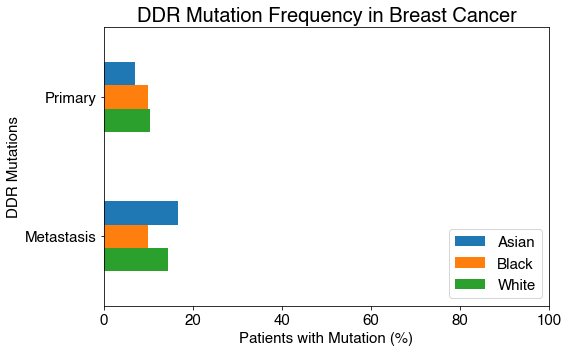

In [159]:
ax = (prim_met_DDR).plot(kind='barh', figsize=(8, 5), width=0.5)
hfont = {'fontname':'Helvetica'}
plt.title('DDR Mutation Frequency in Breast Cancer', fontsize=20, **hfont)
plt.xlabel('Patients with Mutation (%)', fontsize=15, **hfont)
plt.ylabel('DDR Mutations', fontsize=15, **hfont)
plt.xticks(size=15, **hfont)
plt.yticks(size=15, **hfont)
plt.xlim((0, 100))
ax.invert_yaxis()
ax.set_yticklabels(['Primary', 'Metastasis'])
plt.legend(prop={'family': 'Helvetica', 'size': 15}, loc='lower right')
plt.tight_layout()
# plt.savefig('figures/Breast/DDR_Actionable/breast_DDR_Action_all_prim.pdf')

# Total mutation counts

## Count mutations in each patient

In [160]:
# find genes that were sequenced by all panels, using this as our driver gene list
common_genes = combined_panels[combined_panels['SEQ_ASSAY_ID'].apply(len) == 7].index

In [161]:
len(common_genes)

181

In [162]:
# Count number of mutations (specified by list) in each patient, separated by primary/metstastasis and by race

# removing duplicates:
# first choose sample sequenced by later panel
# then if still duplicates, choose the sample with the largest mutation count

# mut_tbl: mutation table in MAF format
# driver_genes: list of driver genes to be counted
# races: list of races to separate by
def count_mutations(mut_tbl, genes, races):
    race_dict = {}
    mut = mut_tbl[mut_tbl['Hugo_Symbol'].isin(genes)]
    # remove assay duplicates
    mut = remove_duplicates(mut)
    
    for race in races:
        # these are patients with >= 1 count
        race_mut = mut[mut['PRIMARY_RACE'] == race]
        race_mut_cnt = race_mut.groupby(['PATIENT_ID', 'SAMPLE_ID'])['SAMPLE_ID'].count()
        
        # for remaining duplicates, choose sample with highest mutation count
        race_mut_cnt = race_mut_cnt.groupby('PATIENT_ID').max()
        
        # find patients with zero counts and add them back in
        zero_IDs = mut_tbl[(mut_tbl['PRIMARY_RACE'] == race) & 
                           ~(mut_tbl['PATIENT_ID'].isin(race_mut_cnt.index))]['PATIENT_ID'].unique()
        zero_mut_cnt = pd.Series(index=zero_IDs, data=0)
        
        total_cnt = pd.concat([race_mut_cnt, zero_mut_cnt], axis=0)
        total_cnt = total_cnt.rename('Mutation Count')

        race_dict[race] = total_cnt
    
    return race_dict

In [163]:
driver_dict = {}

In [164]:
for key, value in var_mut_dict.items():
    driver_dict[key] = count_mutations(value, common_genes, races)

## Mean and Median

In [165]:
median_dict = {}

In [166]:
for key, value in driver_dict.items():
    means = []
    medians = []
    for race in races:
        medians.append(np.median(value[race]))
        means.append(np.mean(value[race]))
    df = pd.DataFrame(np.array([means, medians]), index=['Mean', 'Median'], columns=races)
    median_dict[key] = df

In [167]:
median_dict['prim']

,Asian,Black,White
Mean,2.844221,2.918519,2.996735
Median,3.000000,3.000000,2.000000


In [168]:
median_dict['met']

,Asian,Black,White
Mean,3.189394,3.051813,3.914782
Median,3.000000,3.000000,3.000000


In [169]:
# median_dict['prim'].to_csv('tables/breast/breast_prim_median_count.txt', sep='\t')

In [170]:
# median_dict['met'].to_csv('tables/breast/breast_met_median_count.txt', sep='\t')

## Calculate significance (Wilcoxon Rank Sum)

In [171]:
# calculate if distribution of mutation counts is different between races, including outliers
# using Wilcoxon because mutation counts of each race is not normally distributed (tested using shapiro-wilk test)
# also calculate percent difference of median count between races

In [172]:
driver_pval_dict = {}

In [173]:
# calculates the confidence interval of difference of medians for wilcoxon rank sum test
# taken from here: https://gist.github.com/meetbash/aa5dbbeae746a173c5421ac57b45fe70#file-non_param_paired_ci-py

def non_param_unpaired_CI(sample1, sample2, conf):
    n1 = len(sample1)  
    n2 = len(sample2)  
    alpha = 1-conf      
    N = stats.norm.ppf(1 - alpha/2) 
    # The confidence interval for the difference between the two population
    # medians is derived through the n x m differences.
    diffs = sorted([i-j for i in sample1 for j in sample2])
    # the Kth smallest to the Kth largest of the n x m differences then determine 
    # the confidence interval, where K is:
    k = np.math.ceil(n1*n2/2 - (N * (n1*n2*(n1+n2+1)/12)**0.5))
    CI = (round(diffs[k-1],3), round(diffs[len(diffs)-k],3))
    return CI

In [174]:
for key, value in driver_dict.items():
    df = pd.DataFrame(index=['Rank Sum Stat', 'p-value', 'CI', 'Mean Percent Difference'])
    for group in groups:
        pct_diff = (np.mean(value[group[0]]) - np.mean(value[group[1]])) / np.mean(value[group[1]]) * 100
        CI = non_param_unpaired_CI(value[group[0]], value[group[1]], 0.95)
        df[group[0] + '_' + group[1]] = list(stats.ranksums(value[group[0]], value[group[1]])) + [CI] + [pct_diff]
    driver_pval_dict[key] = df

In [175]:
print('Primary Stats:')
driver_pval_dict['prim']

Primary Stats:


,Black_White,Black_Asian,Asian_White
Rank Sum Stat,0.439364,-0.132698,0.583205
p-value,0.660398,0.894432,0.559755
CI,"(0, 0)","(0, 0)","(0, 0)"
Mean Percent Difference,-2.61005,2.61222,-5.08933


In [176]:
print('Metastatic Stats:')
driver_pval_dict['met']

Metastatic Stats:


,Black_White,Black_Asian,Asian_White
Rank Sum Stat,-3.95173,-0.714007,-2.43616
p-value,7.75893e-05,0.475223,0.014844
CI,"(-1, 0)","(-1, 0)","(-1, 0)"
Mean Percent Difference,-22.0438,-4.31369,-18.5295


In [177]:
# driver_pval_dict['prim'].to_csv('tables/breast/breast_prim_count_stats.txt', sep='\t')

In [178]:
# driver_pval_dict['met'].to_csv('tables/breast/breast_met_count_stats.txt', sep='\t')

## Box Plot

In [179]:
driver_count_dict = {}

In [180]:
for key, value in driver_dict.items():
    dfs = []
    for race in races:
        df = pd.DataFrame(value[race])
        df['Race'] = race
        if key == 'prim':
            df['Sample Type'] = 'Primary'
        else:
            df['Sample Type'] = 'Metastasis'
        dfs.append(df)
    driver_count_dict[key] = pd.concat(dfs)   

In [181]:
driver_df = pd.concat([driver_count_dict['prim'], driver_count_dict['met']])

### Try a log scale

In [182]:
# adding 1 to prevent infinity values
driver_df['log10(Mutation Count)'] = np.log10(driver_df['Mutation Count'] + 1)

''

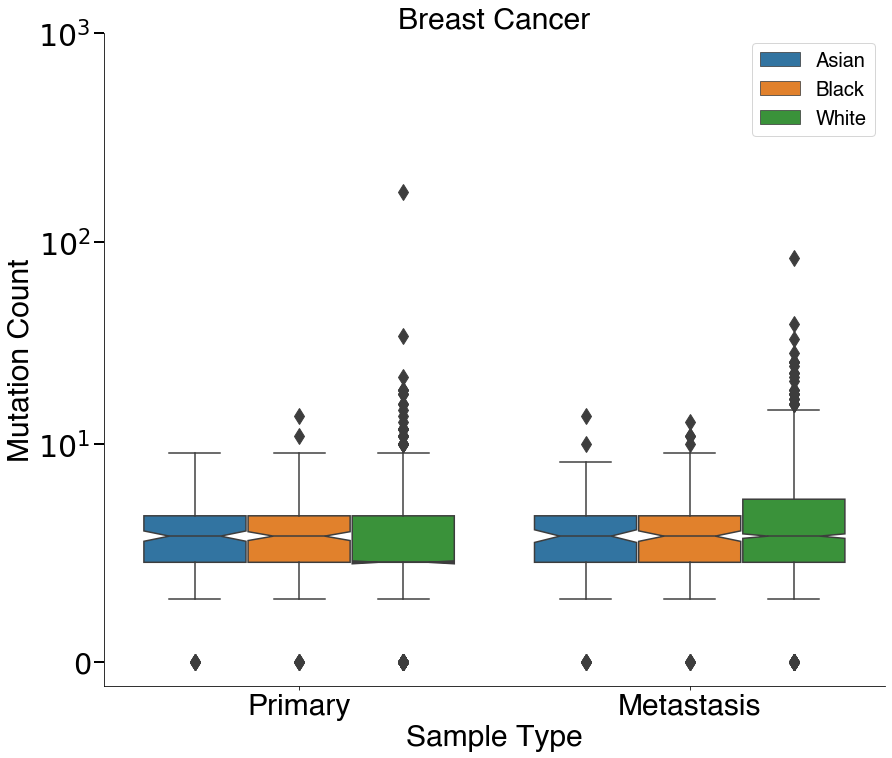

In [183]:
plt.figure(figsize=(14, 12))
ax = sns.boxplot(data=driver_df[['log10(Mutation Count)', 'Race', 'Sample Type']], 
                 hue='Race', x='Sample Type', y='log10(Mutation Count)', notch=True, fliersize=12,
#                 width=
                )
# plt.ylim(-0.1, 3)
# ax.set_xlim(-0.55, 1.55)
sns.despine(ax=ax)

hfont = {'fontname':'Helvetica'}
plt.title('Breast Cancer', size=30, **hfont)
plt.xlabel('Sample Type', size=30, **hfont)
plt.ylabel('Mutation Count', size=30, **hfont)
plt.xticks(fontsize=30, **hfont)
ax.set_yticks([np.log10(1), np.log10(11), np.log10(101), np.log10(1001)])
ax.set_yticklabels(['0', '$10^1$', '$10^2$', '$10^3$'])
plt.yticks(fontsize=30, **hfont)
plt.tick_params('y', length=10, width=2, which='major')


plt.legend(loc='upper right', prop={"family":"Helvetica", 'size':20})
# plt.savefig("figures/breast/breast_boxplot_v3.pdf", bbox_inches='tight')
;